In [1]:
%%bash
   export JAVA_OPTS="-Xmx8g"

In [2]:
!java -XX:+PrintFlagsFinal -version

[Global flags]
      int ActiveProcessorCount                     = -1                                        {product} {default}
    uintx AdaptiveSizeDecrementScaleFactor         = 4                                         {product} {default}
    uintx AdaptiveSizeMajorGCDecayTimeScale        = 10                                        {product} {default}
    uintx AdaptiveSizePolicyCollectionCostMargin   = 50                                        {product} {default}
    uintx AdaptiveSizePolicyInitializingSteps      = 20                                        {product} {default}
    uintx AdaptiveSizePolicyOutputInterval         = 0                                         {product} {default}
    uintx AdaptiveSizePolicyWeight                 = 10                                        {product} {default}
    uintx AdaptiveSizeThroughPutPolicy             = 0                                         {product} {default}
    uintx AdaptiveTimeWeight                       = 25          

In [3]:
!pip install kaggle
!kaggle datasets download -d sunnykakar/spotify-charts-all-audio-data

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: line 1: kaggle: command not found


In [4]:
!unzip spotify-charts-all-audio-data.zip

unzip:  cannot find or open spotify-charts-all-audio-data.zip, spotify-charts-all-audio-data.zip.zip or spotify-charts-all-audio-data.zip.ZIP.


In [5]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Data Exploration

## Preliminary Exploration

In [7]:
# Inspect schema of an initial load of the data.

data_path = 'spotify-charts-all-audio-data/merged_data.csv'

try:
    rawload = sqlContext.read.csv(data_path, header = True)
    rawload.printSchema()
except Exception:
    print(f'Error loading "{data_path}".')

root
 |-- _c0: string (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: string (nullable = true)
 |-- af_energy: string (nullable = true)
 |-- af_key: string (nullable = true)
 |-- af_loudness: string (nullable = true)
 |-- af_mode: string (nullable = true)
 |-- af_speechiness: string (nullable = true)
 |-- af_acousticness: string (nullable = true)
 |-- af_instrumentalness: strin

In [8]:
# Show the first 5 rows of raw data
rawload.head(5)

[Row(_c0='0', title='Chantaje (feat. Maluma)', rank='1', date='2017-01-01', artist='Shakira', url='https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg', region='Argentina', chart='top200', trend='SAME_POSITION', streams='253019.0', track_id='6mICuAdrwEjh6Y6lroV2Kg', album='El Dorado', popularity='78.0', duration_ms='195840.0', explicit='False', release_date='2017-05-26', available_markets="['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'TZ', 'UG', 'AG', 'AM'

In [9]:
# Rename the first column, which refers to a primary key that was blandly named '_c0' by default.

df = rawload.withColumnRenamed('_c0', 'ID')

In [10]:
# Count observations in the dataset.

df_ct = df.count()
print(f'There are {df_ct} observations in this dataset.')

There are 26174269 observations in this dataset.


## Getting Summary Statistics for Numeric Attributes

In [11]:
# As the above schema shows, all attributes assume the string type, even though many of them are numeric. View a
# single observation to determine which attributes are numeric.

print(f'SAMPLE OBSERVATION:\n\n{df.take(1)}')

SAMPLE OBSERVATION:

[Row(ID='0', title='Chantaje (feat. Maluma)', rank='1', date='2017-01-01', artist='Shakira', url='https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg', region='Argentina', chart='top200', trend='SAME_POSITION', streams='253019.0', track_id='6mICuAdrwEjh6Y6lroV2Kg', album='El Dorado', popularity='78.0', duration_ms='195840.0', explicit='False', release_date='2017-05-26', available_markets="['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'T

In [12]:
# Evaluating the above observation allows us to establish which attributes are numeric.

numeric_attributes = ['ID', 'rank', 'streams', 'popularity', 'duration_ms', 'af_danceability', 'af_energy',
                      'af_key', 'af_loudness', 'af_mode', 'af_speechiness', 'af_acousticness',
                      'af_instrumentalness', 'af_liveness', 'af_valence', 'af_tempo',  'af_time_signature']
df[numeric_attributes].show(5)

+---+----+--------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
| ID|rank| streams|popularity|duration_ms|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|
+---+----+--------+----------+-----------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
|  0|   1|253019.0|      78.0|   195840.0|          0.852|    0.773|   8.0|     -2.921|    0.0|        0.0776|          0.187|           3.05e-05|      0.159|     0.907| 102.034|              4.0|
|  1|   2|223988.0|      72.0|   259195.0|          0.663|     0.92|  11.0|      -4.07|    0.0|         0.226|        0.00431|           1.69e-05|      0.101|     0.533|  99.935|              4.0|
|  2|   3|21094

In [13]:
# We'll have to cast numeric attributes to floats to explore these attributes.

df = df.withColumns(dict(zip(numeric_attributes, [df[attribute].cast('float') for attribute in
                                                  numeric_attributes])))

In [14]:
# Confirm that type casting was correctly implemented.

print('UPDATED SCHEMA:\n')
df.printSchema()
print(f'\n\nSAMPLE OBSERVATION:\n\n{df.take(1)}')

UPDATED SCHEMA:

root
 |-- ID: float (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: float (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: float (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: float (nullable = true)
 |-- af_energy: float (nullable = true)
 |-- af_key: float (nullable = true)
 |-- af_loudness: float (nullable = true)
 |-- af_mode: float (nullable = true)
 |-- af_speechiness: float (nullable = true)
 |-- af_acousticness: float (nullable = true)
 |-- af_instrumentalness: f

In [15]:
# Now that we've casted numeric attributes to floats, we can generate summary statistics for them.

nas = df[numeric_attributes].describe()

In [16]:
# We can display summary statistics in a visually appealing format by implementing the following.

for attribute in numeric_attributes:
    nas[['summary', attribute]].show()

+-------+-----------------+
|summary|               ID|
+-------+-----------------+
|  count|         26174269|
|   mean|      1.3087134E7|
| stddev|7555860.770833806|
|    min|              0.0|
|    max|      2.6174268E7|
+-------+-----------------+

+-------+------------------+
|summary|              rank|
+-------+------------------+
|  count|          26172127|
|   mean|  80.9233979339929|
| stddev|59.185732716119134|
|    min|               1.0|
|    max|             200.0|
+-------+------------------+

+-------+------------------+
|summary|           streams|
+-------+------------------+
|  count|          20318240|
|   mean|55266.480036705936|
| stddev|209601.75006362287|
|    min|            1001.0|
|    max|       1.9749704E7|
+-------+------------------+

+-------+-----------------+
|summary|       popularity|
+-------+-----------------+
|  count|         25853279|
|   mean|46.71695659958646|
| stddev|32.81488206233617|
|    min|              0.0|
|    max|          19176.0|

## Missing Data

In [17]:
# Determine how many null values there are per attribute, and write findings to
# a new file.

nulls_dict = {}
with open('missing_info.txt', 'w') as file:
  for i, attribute in enumerate(df.columns):
    null_IDs = df[['ID']].where(df[attribute].isNull())
    nulls_dict[attribute] = (null_IDs, null_IDs.count())
    file.write(f'Attribute "{attribute}" contains {nulls_dict[attribute][1]} ' +
               f'nulls ({round((nulls_dict[attribute][1]/df_ct)*100, 2)}%).\n')
    print(f'Writing to "missing_info.txt"' +
          f'... {round(100 * (i + 1) / len(df.columns), 2)}% complete.')
print('Done!')

Writing to "missing_info.txt"... 3.45% complete.
Writing to "missing_info.txt"... 6.9% complete.
Writing to "missing_info.txt"... 10.34% complete.
Writing to "missing_info.txt"... 13.79% complete.
Writing to "missing_info.txt"... 17.24% complete.
Writing to "missing_info.txt"... 20.69% complete.
Writing to "missing_info.txt"... 24.14% complete.
Writing to "missing_info.txt"... 27.59% complete.
Writing to "missing_info.txt"... 31.03% complete.
Writing to "missing_info.txt"... 34.48% complete.
Writing to "missing_info.txt"... 37.93% complete.
Writing to "missing_info.txt"... 41.38% complete.
Writing to "missing_info.txt"... 44.83% complete.
Writing to "missing_info.txt"... 48.28% complete.
Writing to "missing_info.txt"... 51.72% complete.
Writing to "missing_info.txt"... 55.17% complete.
Writing to "missing_info.txt"... 58.62% complete.
Writing to "missing_info.txt"... 62.07% complete.
Writing to "missing_info.txt"... 65.52% complete.
Writing to "missing_info.txt"... 68.97% complete.
Wri

In [18]:
# We can easily view the outputs of the above file.

with open('missing_info.txt', 'r') as file:
  file_contents = file.read()
print(file_contents)

Attribute "ID" contains 0 nulls (0.0%).
Attribute "title" contains 11 nulls (0.0%).
Attribute "rank" contains 2142 nulls (0.01%).
Attribute "date" contains 0 nulls (0.0%).
Attribute "artist" contains 18 nulls (0.0%).
Attribute "url" contains 0 nulls (0.0%).
Attribute "region" contains 0 nulls (0.0%).
Attribute "chart" contains 0 nulls (0.0%).
Attribute "trend" contains 0 nulls (0.0%).
Attribute "streams" contains 5856029 nulls (22.37%).
Attribute "track_id" contains 306669 nulls (1.17%).
Attribute "album" contains 323856 nulls (1.24%).
Attribute "popularity" contains 320990 nulls (1.23%).
Attribute "duration_ms" contains 306767 nulls (1.17%).
Attribute "explicit" contains 304281 nulls (1.16%).
Attribute "release_date" contains 304258 nulls (1.16%).
Attribute "available_markets" contains 304249 nulls (1.16%).
Attribute "af_danceability" contains 320803 nulls (1.23%).
Attribute "af_energy" contains 306654 nulls (1.17%).
Attribute "af_key" contains 304514 nulls (1.16%).
Attribute "af_loud

In [19]:
#Exploring categorical data

categorical_columns = ['region', 'chart', 'trend', 'explicit']
for column in categorical_columns:
    df.groupBy(column).count().orderBy('count', ascending=False).show()

+--------------+------+
|        region| count|
+--------------+------+
|     Argentina|455186|
| United States|454860|
|        Brazil|454426|
|       Austria|454384|
|     Australia|453056|
|        Canada|452096|
|        Global|451688|
|United Kingdom|450617|
|   Switzerland|449491|
|      Malaysia|449338|
|       Denmark|449306|
|         Italy|449299|
|     Indonesia|449292|
|       Belgium|449283|
|        France|449268|
|   Philippines|449249|
|       Ecuador|449226|
|      Colombia|449216|
|       Ireland|449185|
|   New Zealand|449184|
+--------------+------+
only showing top 20 rows

+--------------------+--------+
|               chart|   count|
+--------------------+--------+
|              top200|20318240|
|             viral50| 5848699|
|            Paraguay|     704|
|             Germany|     555|
|               Chile|     516|
|https://open.spot...|     438|
|https://open.spot...|     259|
|               Spain|     231|
|       United States|     214|
|             

In [20]:
#The outputs above can give us a hint on what we can remove from dataset

## Data Visualization

### Popularity vs Streams

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Select subset of data
data_subset = df.select("popularity", "streams").dropna().sample(fraction=0.2)

pandas_df = data_subset.toPandas()

Matplotlib created a temporary cache directory at /scratch/seltawil/job_30679400/matplotlib-tszhs0ca because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


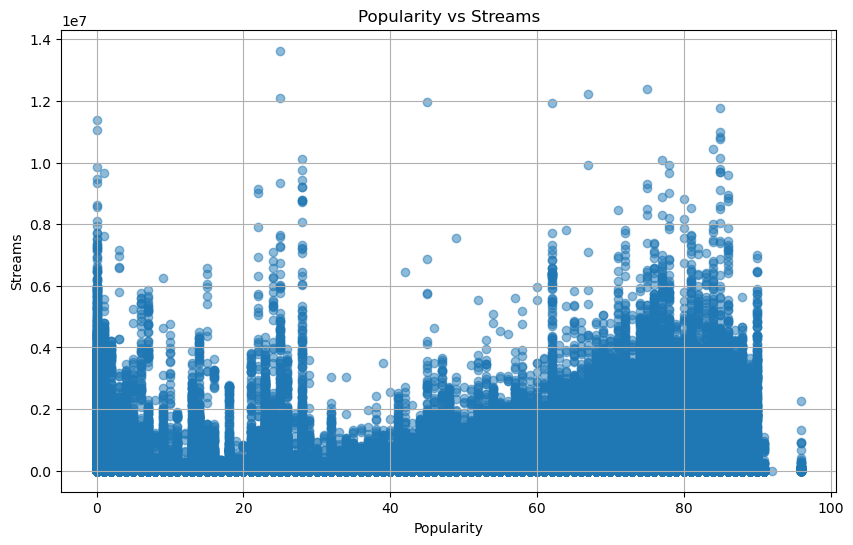

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['popularity'], pandas_df['streams'], alpha=0.5)
plt.title('Popularity vs Streams')
plt.xlabel('Popularity')
plt.ylabel('Streams')
plt.grid(True)
plt.show()

### Duration vs Popularity

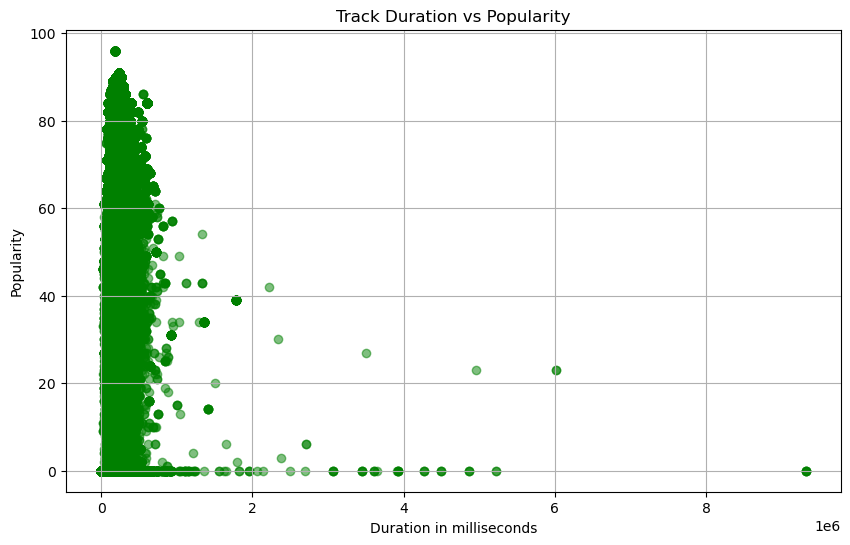

In [23]:
data_subset = df.select(
    col("duration_ms"),
    col("popularity")
).na.drop()

sampled_data = data_subset.sample(fraction=0.1)
pandas_df = sampled_data.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['duration_ms'], pandas_df['popularity'], alpha=0.5, color='green')
plt.title('Track Duration vs Popularity')
plt.xlabel('Duration in milliseconds')
plt.ylabel('Popularity')
plt.grid(True)
plt.show()

### Stream vs Explicitness

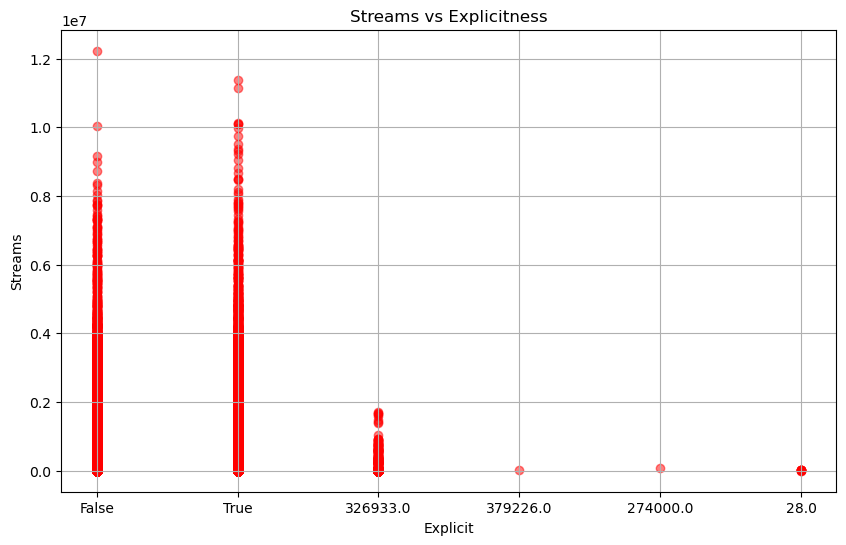

In [24]:
explicit_streams = df.select(
    col("explicit"),
    col("streams")
).na.drop()

sampled_explicit_streams = explicit_streams.sample(fraction=0.1)

# Collect and plot
pandas_explicit_streams = sampled_explicit_streams.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(pandas_explicit_streams['explicit'], pandas_explicit_streams['streams'], alpha=0.5, color='red')
plt.title('Streams vs Explicitness')
plt.xlabel('Explicit')
plt.ylabel('Streams')
plt.grid(True)
plt.show()

### Popularity vs Region

<Figure size 1200x800 with 0 Axes>

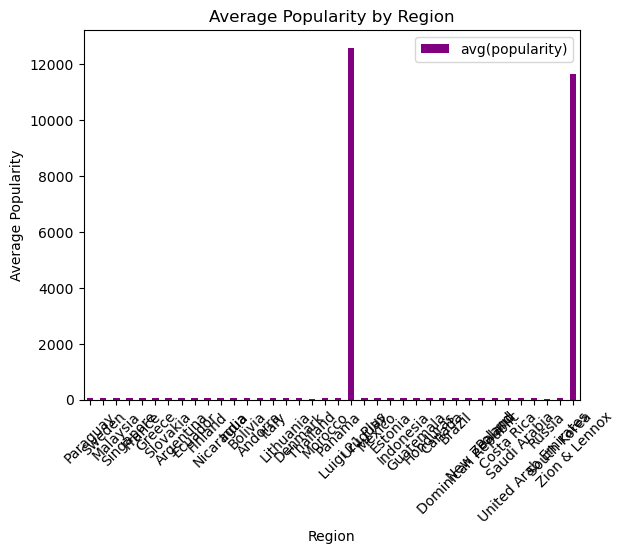

In [25]:
region_popularity = df.groupBy("region").agg({'popularity': 'avg'}).na.drop()

sampled_region_popularity = region_popularity.sample(fraction=0.4)

pandas_region_popularity = sampled_region_popularity.toPandas()

plt.figure(figsize=(12, 8))
pandas_region_popularity.plot(kind='bar', x='region', y='avg(popularity)', color='purple')
plt.title('Average Popularity by Region')
plt.xlabel('Region')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.show()

### Energy vs Loudness

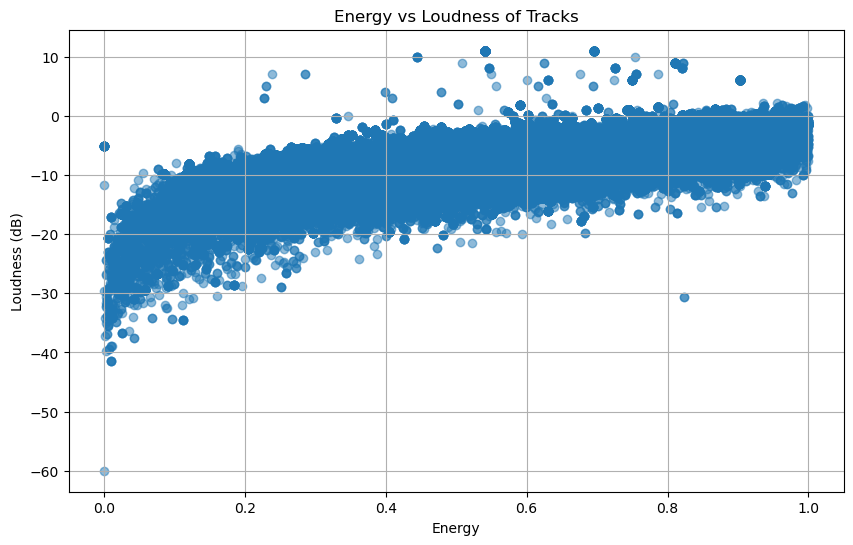

In [26]:
energy_loudness = df.select(
    col("af_energy"),
    col("af_loudness")
).na.drop().sample(fraction=0.1)

pandas_energy_loudness = energy_loudness.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pandas_energy_loudness['af_energy'], pandas_energy_loudness['af_loudness'], alpha=0.5)
plt.title('Energy vs Loudness of Tracks')
plt.xlabel('Energy')
plt.ylabel('Loudness (dB)')
plt.grid(True)
plt.show()

### Tempo vs Danceability

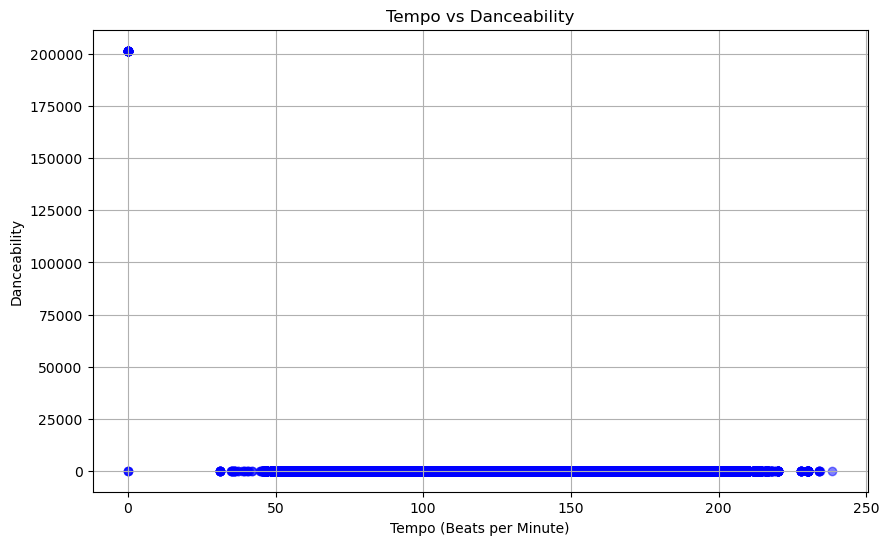

In [27]:
tempo_danceability = df.select(
    col("af_tempo"),
    col("af_danceability")
).na.drop().sample(fraction=0.1)

pandas_tempo_danceability = tempo_danceability.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pandas_tempo_danceability['af_tempo'], pandas_tempo_danceability['af_danceability'], alpha=0.5, color='blue')
plt.title('Tempo vs Danceability')
plt.xlabel('Tempo (Beats per Minute)')
plt.ylabel('Danceability')
plt.grid(True)
plt.show()

### Valence vs Acousticness

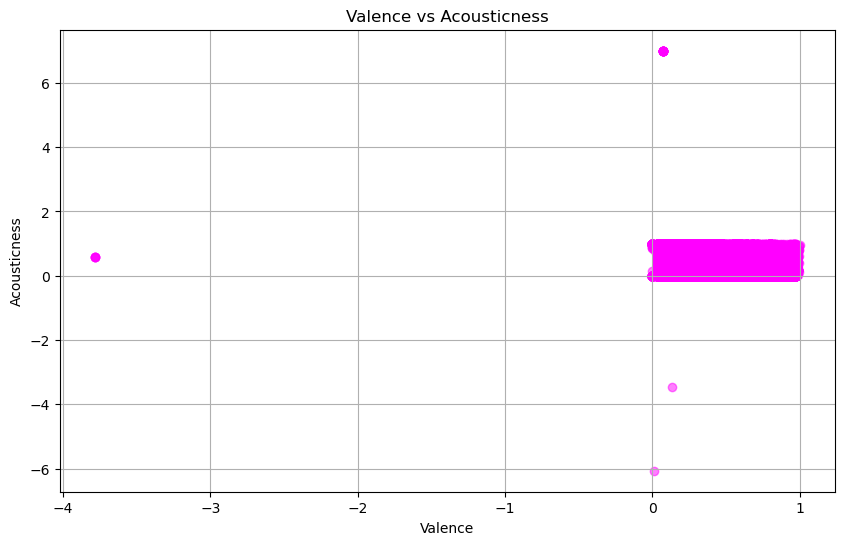

In [28]:
valence_acousticness = df.select(
    col("af_valence"),
    col("af_acousticness")
).na.drop().sample(fraction=0.1)

pandas_valence_acousticness = valence_acousticness.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pandas_valence_acousticness['af_valence'], pandas_valence_acousticness['af_acousticness'], alpha=0.5, color='magenta')
plt.title('Valence vs Acousticness')
plt.xlabel('Valence')
plt.ylabel('Acousticness')
plt.grid(True)
plt.show()

### Popularity by Release Year

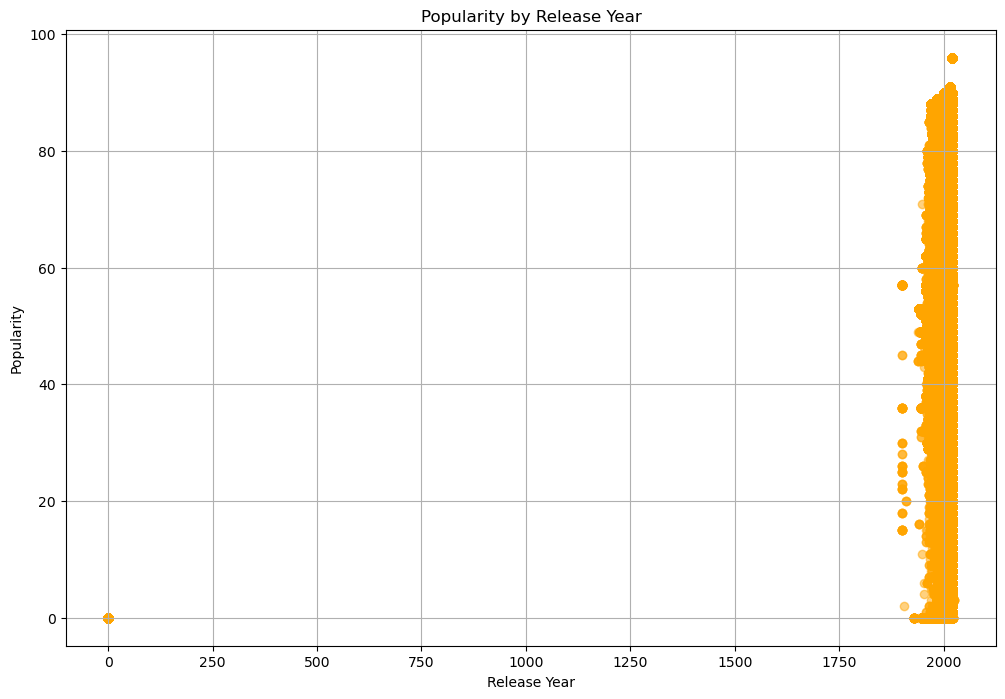

In [29]:
from pyspark.sql.functions import year

popularity_year = df.select(
    year(col("release_date")).alias("release_year"),
    col("popularity")
).na.drop().sample(fraction=0.3)

pandas_popularity_year = popularity_year.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(pandas_popularity_year['release_year'], pandas_popularity_year['popularity'], alpha=0.5, color='orange')
plt.title('Popularity by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Popularity')
plt.grid(True)
plt.show()

# Data cleaning



In [30]:
# See if there are any anomalies in missing data.

with open('missing_info.txt', 'r') as file:
  file_contents = file.read()
print(file_contents)

Attribute "ID" contains 0 nulls (0.0%).
Attribute "title" contains 11 nulls (0.0%).
Attribute "rank" contains 2142 nulls (0.01%).
Attribute "date" contains 0 nulls (0.0%).
Attribute "artist" contains 18 nulls (0.0%).
Attribute "url" contains 0 nulls (0.0%).
Attribute "region" contains 0 nulls (0.0%).
Attribute "chart" contains 0 nulls (0.0%).
Attribute "trend" contains 0 nulls (0.0%).
Attribute "streams" contains 5856029 nulls (22.37%).
Attribute "track_id" contains 306669 nulls (1.17%).
Attribute "album" contains 323856 nulls (1.24%).
Attribute "popularity" contains 320990 nulls (1.23%).
Attribute "duration_ms" contains 306767 nulls (1.17%).
Attribute "explicit" contains 304281 nulls (1.16%).
Attribute "release_date" contains 304258 nulls (1.16%).
Attribute "available_markets" contains 304249 nulls (1.16%).
Attribute "af_danceability" contains 320803 nulls (1.23%).
Attribute "af_energy" contains 306654 nulls (1.17%).
Attribute "af_key" contains 304514 nulls (1.16%).
Attribute "af_loud

In [31]:
# As expected, many columns contain a significant proportion of nulls. (e.g.,
# "streams"). In preprocessing our data, handling such columns is especially
# important. Depending on the details of our analysis and the proportion of
# nulls contained in a given column, we may choose to drop or impute values on
# attributes containing nulls. E.g., if we sought to drop the "streams"
# attribute, we could simply implement the following:

df = df.drop('streams')
'streams' in df.columns

False

In [32]:
# Similarly, we may check if there are any rows which are entirely empty in our
# dataset.

emptyRowFinder = df
for attribute in df.columns[1:]:
  emptyRowFinder = emptyRowFinder.where(emptyRowFinder[attribute].isNull())
emptyRowFinder.show()

# As the below output shows, there are fortunately no entirely empty rows that
# need to be cleaned out of our dataset.

+---+-----+----+----+------+---+------+-----+-----+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
| ID|title|rank|date|artist|url|region|chart|trend|track_id|album|popularity|duration_ms|explicit|release_date|available_markets|af_danceability|af_energy|af_key|af_loudness|af_mode|af_speechiness|af_acousticness|af_instrumentalness|af_liveness|af_valence|af_tempo|af_time_signature|
+---+-----+----+----+------+---+------+-----+-----+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---------+------+-----------+-------+--------------+---------------+-------------------+-----------+----------+--------+-----------------+
+---+-----+----+----+------+---+------+-----+-----+--------+-----+----------+-----------+--------+------------+-----------------+---------------+---

In [33]:
df.head(10)

[Row(ID=0.0, title='Chantaje (feat. Maluma)', rank=1.0, date='2017-01-01', artist='Shakira', url='https://open.spotify.com/track/6mICuAdrwEjh6Y6lroV2Kg', region='Argentina', chart='top200', trend='SAME_POSITION', track_id='6mICuAdrwEjh6Y6lroV2Kg', album='El Dorado', popularity=78.0, duration_ms=195840.0, explicit='False', release_date='2017-05-26', available_markets="['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'TZ', 'UG', 'AG', 'AM', 'BS', 'BB', 'BZ', 'BT',


# Major Preprocessing
This section includes scaling, imputing, encoding, and feature expansion.
        

Convert Columns to Float


In [34]:
from pyspark.sql.functions import col, regexp_replace

# Define the correct numeric attributes based on the schema
numeric_attributes = [
    'rank', 'popularity', 'duration_ms', 'af_danceability', 'af_energy', 'af_key',
    'af_loudness', 'af_mode', 'af_speechiness', 'af_acousticness', 'af_instrumentalness',
    'af_liveness', 'af_valence', 'af_tempo', 'af_time_signature'
]

# Remove non-numeric characters and cast columns to float
for column in numeric_attributes:
    df = df.withColumn(column, regexp_replace(col(column), '[^0-9.-]', '').cast('float'))

# Verify the schema to ensure correct types
df.printSchema()

root
 |-- ID: float (nullable = true)
 |-- title: string (nullable = true)
 |-- rank: float (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- explicit: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- available_markets: string (nullable = true)
 |-- af_danceability: float (nullable = true)
 |-- af_energy: float (nullable = true)
 |-- af_key: float (nullable = true)
 |-- af_loudness: float (nullable = true)
 |-- af_mode: float (nullable = true)
 |-- af_speechiness: float (nullable = true)
 |-- af_acousticness: float (nullable = true)
 |-- af_instrumentalness: float (nullable = true)
 |-- af_liveness: float (nullabl

In [35]:
from pyspark.ml.feature import Imputer, StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

# Imputing missing data
imputer = Imputer(inputCols=numeric_attributes, outputCols=[f"{col}_imputed" for col in numeric_attributes])
df_imputed = imputer.fit(df).transform(df)

# Standardizing numeric features
assembler = VectorAssembler(inputCols=[f"{col}_imputed" for col in numeric_attributes], outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features")
df_assembled = assembler.transform(df_imputed)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

In [36]:
# Select categorical columns
categorical_cols = ['region', 'chart', 'trend', 'explicit']

# Encoding categorical features
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed").setHandleInvalid('keep')
            for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded") for col in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df_scaled).transform(df_scaled)

In [39]:
# Prepare features for clustering
features_for_clustering = ['scaled_features'] + [f"{col}_encoded" for col in categorical_cols]
assembler_clustering = VectorAssembler(inputCols=features_for_clustering, outputCol="features")
df_features = assembler_clustering.transform(df_encoded)

In [42]:
# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(2, 11)
for k in K:
    try:
        gc.collect()
        kmeans = KMeans(k=k, seed=42, featuresCol='features')
        model = kmeans.fit(df_features)
        inertia.append(model.summary.trainingCost)
        print(f'{k - 1} models trained so far')
    except:
        print(f'Resources exhausted after successfully training {k - 2} models! Aborting model training.')
        break

5 models trained so far
6 models trained so far
7 models trained so far
8 models trained so far
9 models trained so far


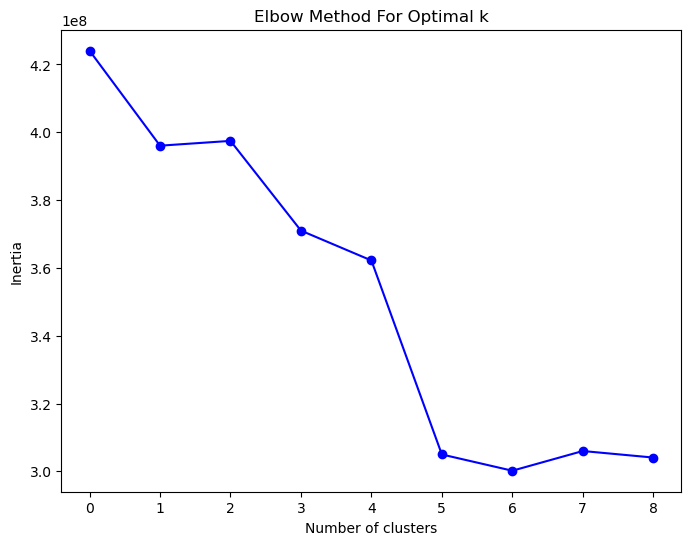

In [49]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
# Fit KMeans with the optimal number of clusters
optimal_k = 5  # Assuming 5 is the optimal number of clusters from the elbow method
                # Update: k = 5 really did end up being optimal as the elbow graph above confirms!
kmeans = KMeans(k=optimal_k, seed=42, featuresCol='features')
model = kmeans.fit(df_features)
clusters = model.transform(df_features)

In [73]:
# Get count of rows in each cluster
cluster_counts = clusters.groupby('prediction').count().collect()
cluster_counts

[Row(prediction=1, count=10159167),
 Row(prediction=4, count=8032346),
 Row(prediction=2, count=4399633),
 Row(prediction=0, count=3583088),
 Row(prediction=3, count=35)]

In [ ]:
sample_sizes = 35
samples = dict()
for row in cluster_counts:
    sample_ratio = float(min(1, sample_sizes / row['count']))
    df2sample = clusters.where(clusters['prediction'] == row['prediction'])
    samples[row['prediction']] = clusters.where(clusters['prediction'] ==
                                                row['prediction']).sample(fraction = sample_ratio)

In [92]:
# Verify that every sample has roughly 35 rows.
[samples[i].count() for i in range(optimal_k)]

[38, 35, 36, 35, 37]

In [122]:
# Save samples.

cpath = input('Please specify directory to which samples can be saved:')
samples_path = [cpath + '/sample' + str(i) for i in range(optimal_k)]
for i in range(optimal_k):
    samples[i].rdd.saveAsPickleFile(samples_path[i])

Please specify directory to which samples can be saved: /home/seltawil


In [127]:
!tar cvf sample0.tar.gz sample0
!tar cvf sample1.tar.gz sample1
!tar cvf sample2.tar.gz sample2
!tar cvf sample3.tar.gz sample3
!tar cvf sample4.tar.gz sample4

sample0/
sample0/.part-00090.crc
sample0/.part-00041.crc
sample0/.part-00119.crc
sample0/part-00049
sample0/part-00133
sample0/part-00144
sample0/part-00043
sample0/part-00034
sample0/part-00139
sample0/.part-00165.crc
sample0/.part-00162.crc
sample0/.part-00097.crc
sample0/.part-00046.crc
sample0/part-00198
sample0/.part-00034.crc
sample0/part-00176
sample0/part-00101
sample0/part-00095
sample0/.part-00099.crc
sample0/.part-00048.crc
sample0/.part-00110.crc
sample0/part-00192
sample0/part-00006
sample0/part-00071
sample0/.part-00117.crc
sample0/.part-00200.crc
sample0/.part-00033.crc
sample0/part-00050
sample0/part-00027
sample0/.part-00122.crc
sample0/part-00120
sample0/part-00157
sample0/.part-00006.crc
sample0/.part-00001.crc
sample0/.part-00188.crc
sample0/.part-00159.crc
sample0/.part-00125.crc
sample0/part-00118
sample0/part-00181
sample0/part-00015
sample0/part-00062
sample0/.part-00186.crc
sample0/.part-00157.crc
sample0/.part-00073.crc
sample0/part-00165
sample0/part-00112
sa